# 02456 Deep Learning - Feedforward Neural Network Experiments
### Vignesh Sethuraman (s252755), Sai Shashank Maktala (s253062)

This notebook demonstrates the key experiments from our project: implementing a feedforward neural network from scratch using NumPy.

**Note**: To keep runtime reasonable, we use fewer epochs (5-10) than the full report (20), but the trends remain consistent.

## 1. Setup and Data Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Import our custom modules
from src.data_loader import load_dataset, train_val_split
from src.model import FeedForwardNN, NetworkConfig
from src.optimizer import Optimizer, OptimizerConfig
from src.trainer import TrainingConfig, train_model, evaluate_model

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Load Fashion-MNIST dataset
print("Loading Fashion-MNIST dataset...")
x_train, y_train, x_test, y_test = load_dataset(
    dataset='fashion_mnist',
    source='keras',
    normalize=True,
    flatten=True
)

# Split into train and validation
x_train, y_train, x_val, y_val = train_val_split(x_train, y_train, validation_split=0.1)

print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")

input_size = x_train.shape[1]
output_size = 10  # Fashion-MNIST has 10 classes

Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (54000, 784)
Validation set: (6000, 784)
Test set: (10000, 784)


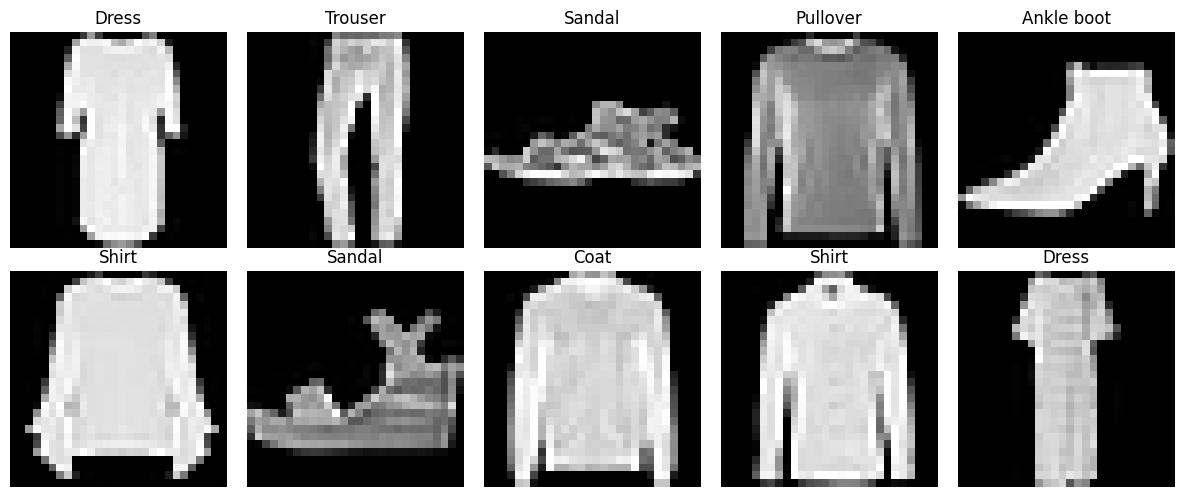

In [3]:
# Visualize sample images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = x_train[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{class_names[y_train[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Experiment 1: Optimizer Comparison

We compare 6 different optimizers: SGD, Momentum, Nesterov, RMSprop, Adam, and Nadam.

**Configuration**: [128, 64] architecture, ReLU activation, L2=0.0, 10 epochs

In [4]:
optimizers_to_test = ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
optimizer_results = {}

for opt_name in optimizers_to_test:
    print(f"\n{'='*60}")
    print(f"Training with {opt_name.upper()} optimizer")
    print(f"{'='*60}")
    
    # Create model
    net_config = NetworkConfig(
        input_size=input_size,
        hidden_sizes=[128, 64],
        output_size=output_size,
        activation='relu',
        output_activation='softmax',
        weight_init='he',
        l2_coeff=0.0
    )
    model = FeedForwardNN(net_config)
    
    # Create optimizer
    opt_config = OptimizerConfig(
        optimizer_type=opt_name,
        learning_rate=0.001,
        momentum=0.9,
        beta=0.9,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8
    )
    optimizer = Optimizer(opt_config)
    
    # Train
    train_cfg = TrainingConfig(
        batch_size=64,
        num_epochs=10,
        loss='cross_entropy',
        use_wandb=True  # Experiments tracked via WandB
    )
    
    history = train_model(model, optimizer, x_train, y_train, x_val, y_val, config=train_cfg)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, x_test, y_test, loss='cross_entropy')
    
    optimizer_results[opt_name] = {
        'history': history,
        'test_accuracy': test_metrics['test_accuracy'],
        'train_accuracy': history['train_accuracy'][-1],
        'val_accuracy': history['val_accuracy'][-1]
    }
    
    print(f"\nTest Accuracy: {test_metrics['test_accuracy']:.4f}")


Training with SGD optimizer
Epoch 1/10 - Train Loss: 2.8563, Train Acc: 0.1050, Val Loss: 2.7589, Val Acc: 0.1145
Epoch 2/10 - Train Loss: 2.6835, Train Acc: 0.1082, Val Loss: 2.6239, Val Acc: 0.1178
Epoch 3/10 - Train Loss: 2.5718, Train Acc: 0.1125, Val Loss: 2.5303, Val Acc: 0.1247
Epoch 4/10 - Train Loss: 2.4910, Train Acc: 0.1212, Val Loss: 2.4592, Val Acc: 0.1363
Epoch 5/10 - Train Loss: 2.4278, Train Acc: 0.1384, Val Loss: 2.4016, Val Acc: 0.1595
Epoch 6/10 - Train Loss: 2.3756, Train Acc: 0.1646, Val Loss: 2.3533, Val Acc: 0.1842
Epoch 7/10 - Train Loss: 2.3312, Train Acc: 0.1917, Val Loss: 2.3123, Val Acc: 0.2088
Epoch 8/10 - Train Loss: 2.2931, Train Acc: 0.2177, Val Loss: 2.2767, Val Acc: 0.2330
Epoch 9/10 - Train Loss: 2.2595, Train Acc: 0.2430, Val Loss: 2.2451, Val Acc: 0.2562
Epoch 10/10 - Train Loss: 2.2293, Train Acc: 0.2647, Val Loss: 2.2163, Val Acc: 0.2753

Test Accuracy: 0.2702

Training with MOMENTUM optimizer
Epoch 1/10 - Train Loss: 2.2236, Train Acc: 0.2425, V

In [5]:
# Display results table
print("\n" + "="*70)
print("OPTIMIZER COMPARISON RESULTS")
print("="*70)
print(f"{'Optimizer':<15} {'Test Acc':<12} {'Train Acc':<12} {'Gap':<10}")
print("-"*70)

for opt_name in optimizers_to_test:
    res = optimizer_results[opt_name]
    gap = res['train_accuracy'] - res['test_accuracy']
    print(f"{opt_name.capitalize():<15} {res['test_accuracy']*100:>10.2f}% {res['train_accuracy']*100:>10.2f}% {gap*100:>8.2f}%")

print("="*70)


OPTIMIZER COMPARISON RESULTS
Optimizer       Test Acc     Train Acc    Gap       
----------------------------------------------------------------------
Sgd                  27.02%      26.47%    -0.55%
Momentum             68.55%      68.93%     0.38%
Nesterov             64.95%      65.25%     0.30%
Rmsprop              78.23%      82.34%     4.11%
Adam                 82.04%      83.05%     1.01%
Nadam                82.73%      83.57%     0.84%


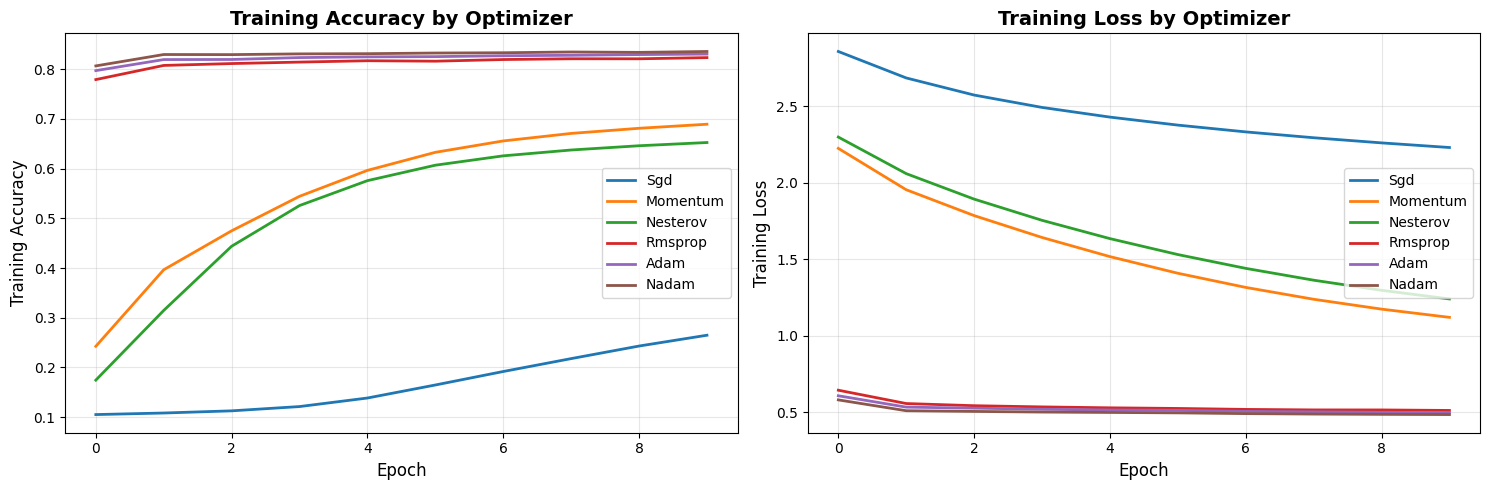

In [6]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy curves
for opt_name in optimizers_to_test:
    history = optimizer_results[opt_name]['history']
    ax1.plot(history['train_accuracy'], label=opt_name.capitalize(), linewidth=2)

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Accuracy', fontsize=12)
ax1.set_title('Training Accuracy by Optimizer', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss curves
for opt_name in optimizers_to_test:
    history = optimizer_results[opt_name]['history']
    ax2.plot(history['train_loss'], label=opt_name.capitalize(), linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Loss', fontsize=12)
ax2.set_title('Training Loss by Optimizer', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment 2: Regularization Impact

We test different L2 regularization coefficients: 0, 1e-5, 1e-4, 1e-3, 1e-2.

**Configuration**: Adam optimizer, [128, 64] architecture, ReLU activation, 10 epochs

In [7]:
l2_values = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
l2_results = {}

for l2_coeff in l2_values:
    print(f"\n{'='*60}")
    print(f"Training with L2 = {l2_coeff}")
    print(f"{'='*60}")
    
    # Create model
    net_config = NetworkConfig(
        input_size=input_size,
        hidden_sizes=[128, 64],
        output_size=output_size,
        activation='relu',
        output_activation='softmax',
        weight_init='he',
        l2_coeff=l2_coeff
    )
    model = FeedForwardNN(net_config)
    
    # Create optimizer
    opt_config = OptimizerConfig(
        optimizer_type='adam',
        learning_rate=0.001,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8
    )
    optimizer = Optimizer(opt_config)
    
    # Train
    train_cfg = TrainingConfig(
        batch_size=64,
        num_epochs=10,
        loss='cross_entropy',
        use_wandb=True  # Experiments tracked via WandB
    )
    
    history = train_model(model, optimizer, x_train, y_train, x_val, y_val, config=train_cfg)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, x_test, y_test, loss='cross_entropy')
    
    l2_results[l2_coeff] = {
        'history': history,
        'test_accuracy': test_metrics['test_accuracy'],
        'train_accuracy': history['train_accuracy'][-1]
    }
    
    print(f"\nTest Accuracy: {test_metrics['test_accuracy']:.4f}")


Training with L2 = 0.0
Epoch 1/10 - Train Loss: 0.5304, Train Acc: 0.8146, Val Loss: 0.4131, Val Acc: 0.8543
Epoch 2/10 - Train Loss: 0.3875, Train Acc: 0.8609, Val Loss: 0.3716, Val Acc: 0.8663
Epoch 3/10 - Train Loss: 0.3442, Train Acc: 0.8755, Val Loss: 0.3507, Val Acc: 0.8747
Epoch 4/10 - Train Loss: 0.3217, Train Acc: 0.8835, Val Loss: 0.3490, Val Acc: 0.8770
Epoch 5/10 - Train Loss: 0.3005, Train Acc: 0.8894, Val Loss: 0.3151, Val Acc: 0.8867
Epoch 6/10 - Train Loss: 0.2862, Train Acc: 0.8936, Val Loss: 0.3007, Val Acc: 0.8922
Epoch 7/10 - Train Loss: 0.2724, Train Acc: 0.8982, Val Loss: 0.3125, Val Acc: 0.8808
Epoch 8/10 - Train Loss: 0.2594, Train Acc: 0.9036, Val Loss: 0.3093, Val Acc: 0.8890
Epoch 9/10 - Train Loss: 0.2521, Train Acc: 0.9049, Val Loss: 0.3046, Val Acc: 0.8848
Epoch 10/10 - Train Loss: 0.2440, Train Acc: 0.9079, Val Loss: 0.2994, Val Acc: 0.8955

Test Accuracy: 0.8829

Training with L2 = 1e-05
Epoch 1/10 - Train Loss: 0.5433, Train Acc: 0.8101, Val Loss: 0.43

In [10]:
# Display results table
print("\n" + "="*70)
print("L2 REGULARIZATION IMPACT")
print("="*70)
print(f"{'L2 Coefficient':<20} {'Test Acc':<12} {'Train Acc':<12} {'Gap':<10}")
print("-"*70)

for l2_coeff in l2_values:
    res = l2_results[l2_coeff]
    gap = res['train_accuracy'] - res['test_accuracy']
    l2_str = f"{l2_coeff:.0e}" if l2_coeff > 0 else "0.0"
    print(f"{l2_str:<20} {res['test_accuracy']*100:>10.2f}% {res['train_accuracy']*100:>10.2f}% {gap*100:>8.2f}%")

print("="*70)


L2 REGULARIZATION IMPACT
L2 Coefficient       Test Acc     Train Acc    Gap       
----------------------------------------------------------------------
0.0                       88.29%      90.79%     2.50%
1e-05                     86.79%      88.11%     1.32%
1e-04                     82.09%      82.82%     0.73%
1e-03                     65.44%      63.99%    -1.45%
1e-02                     10.00%       9.76%    -0.24%


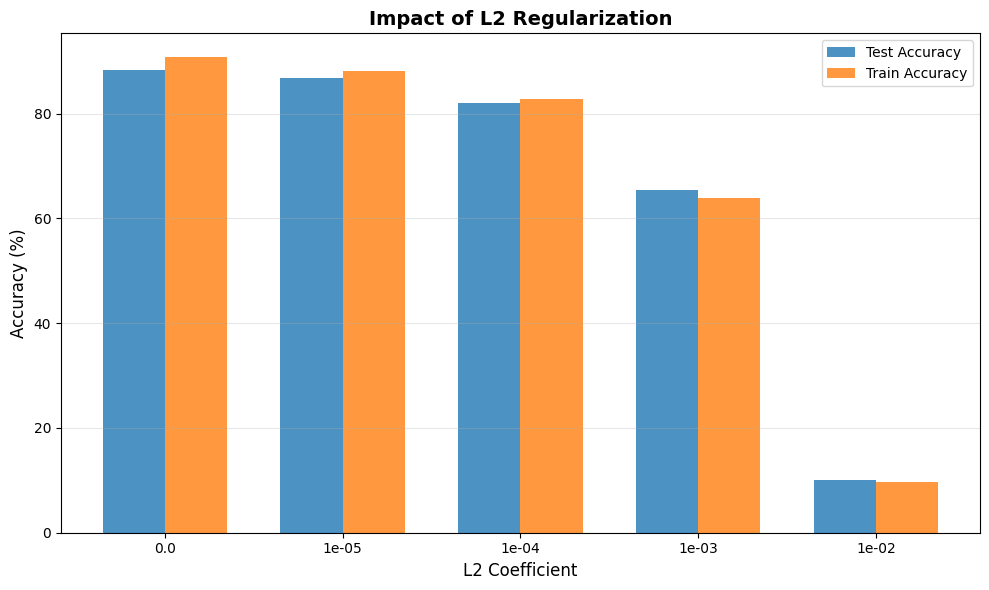

In [11]:
# Plot regularization impact
fig, ax = plt.subplots(figsize=(10, 6))

l2_labels = [f"{l2:.0e}" if l2 > 0 else "0.0" for l2 in l2_values]
test_accs = [l2_results[l2]['test_accuracy'] * 100 for l2 in l2_values]
train_accs = [l2_results[l2]['train_accuracy'] * 100 for l2 in l2_values]

x = np.arange(len(l2_values))
width = 0.35

ax.bar(x - width/2, test_accs, width, label='Test Accuracy', alpha=0.8)
ax.bar(x + width/2, train_accs, width, label='Train Accuracy', alpha=0.8)

ax.set_xlabel('L2 Coefficient', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Impact of L2 Regularization', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(l2_labels)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Experiment 3: Activation Function Comparison

We compare ReLU, Tanh, and Sigmoid activation functions with proper initialization.

**Configuration**: Adam optimizer, [128, 64] architecture, L2=0.0, 10 epochs

In [12]:
activation_configs = [
    ('relu', 'he'),
    ('tanh', 'xavier'),
    ('sigmoid', 'xavier')
]
activation_results = {}

for activation, init_method in activation_configs:
    print(f"\n{'='*60}")
    print(f"Training with {activation.upper()} activation ({init_method} init)")
    print(f"{'='*60}")
    
    # Create model
    net_config = NetworkConfig(
        input_size=input_size,
        hidden_sizes=[128, 64],
        output_size=output_size,
        activation=activation,
        output_activation='softmax',
        weight_init=init_method,
        l2_coeff=0.0
    )
    model = FeedForwardNN(net_config)
    
    # Create optimizer
    opt_config = OptimizerConfig(
        optimizer_type='adam',
        learning_rate=0.001,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8
    )
    optimizer = Optimizer(opt_config)
    
    # Train
    train_cfg = TrainingConfig(
        batch_size=64,
        num_epochs=10,
        loss='cross_entropy',
        use_wandb=True  # Experiments tracked via WandB
    )
    
    history = train_model(model, optimizer, x_train, y_train, x_val, y_val, config=train_cfg)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, x_test, y_test, loss='cross_entropy')
    
    activation_results[activation] = {
        'init': init_method,
        'history': history,
        'test_accuracy': test_metrics['test_accuracy'],
        'train_accuracy': history['train_accuracy'][-1]
    }
    
    print(f"\nTest Accuracy: {test_metrics['test_accuracy']:.4f}")


Training with RELU activation (he init)
Epoch 1/10 - Train Loss: 0.6069, Train Acc: 0.7979, Val Loss: 0.5343, Val Acc: 0.8180
Epoch 2/10 - Train Loss: 0.5309, Train Acc: 0.8199, Val Loss: 0.5205, Val Acc: 0.8212
Epoch 3/10 - Train Loss: 0.5265, Train Acc: 0.8200, Val Loss: 0.5085, Val Acc: 0.8305
Epoch 4/10 - Train Loss: 0.5247, Train Acc: 0.8194, Val Loss: 0.5058, Val Acc: 0.8303
Epoch 5/10 - Train Loss: 0.5199, Train Acc: 0.8211, Val Loss: 0.5027, Val Acc: 0.8332
Epoch 6/10 - Train Loss: 0.5162, Train Acc: 0.8242, Val Loss: 0.5066, Val Acc: 0.8242
Epoch 7/10 - Train Loss: 0.5116, Train Acc: 0.8252, Val Loss: 0.4993, Val Acc: 0.8267
Epoch 8/10 - Train Loss: 0.5100, Train Acc: 0.8250, Val Loss: 0.5051, Val Acc: 0.8290
Epoch 9/10 - Train Loss: 0.5063, Train Acc: 0.8267, Val Loss: 0.5145, Val Acc: 0.8233
Epoch 10/10 - Train Loss: 0.5050, Train Acc: 0.8283, Val Loss: 0.5307, Val Acc: 0.8113

Test Accuracy: 0.8015

Training with TANH activation (xavier init)
Epoch 1/10 - Train Loss: 0.604

In [13]:
# Display results table
print("\n" + "="*70)
print("ACTIVATION FUNCTION COMPARISON")
print("="*70)
print(f"{'Activation':<15} {'Init':<10} {'Test Acc':<12} {'Train Acc':<12}")
print("-"*70)

for activation in ['relu', 'tanh', 'sigmoid']:
    res = activation_results[activation]
    print(f"{activation.upper():<15} {res['init'].capitalize():<10} {res['test_accuracy']*100:>10.2f}% {res['train_accuracy']*100:>10.2f}%")

print("="*70)


ACTIVATION FUNCTION COMPARISON
Activation      Init       Test Acc     Train Acc   
----------------------------------------------------------------------
RELU            He              80.15%      82.83%
TANH            Xavier          81.82%      82.52%
SIGMOID         Xavier          64.96%      67.39%


## 5. Best Model Demonstration

Train the best configuration from our experiments:
- **Optimizer**: Nadam
- **Architecture**: [128, 64]
- **Activation**: Tanh (Xavier initialization)
- **L2 Regularization**: 0.0
- **Epochs**: 15 (for demonstration)

In [14]:
print("Training best model configuration...\n")

# Create best model
net_config = NetworkConfig(
    input_size=input_size,
    hidden_sizes=[128, 64],
    output_size=output_size,
    activation='tanh',
    output_activation='softmax',
    weight_init='xavier',
    l2_coeff=0.0
)
best_model = FeedForwardNN(net_config)

# Create optimizer
opt_config = OptimizerConfig(
    optimizer_type='nadam',
    learning_rate=0.001,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8
)
optimizer = Optimizer(opt_config)

# Train
train_cfg = TrainingConfig(
    batch_size=64,
    num_epochs=15,
    loss='cross_entropy',
    use_wandb=True  # Experiments tracked via WandB
)

best_history = train_model(best_model, optimizer, x_train, y_train, x_val, y_val, config=train_cfg)

# Evaluate on test set
best_test_metrics = evaluate_model(best_model, x_test, y_test, loss='cross_entropy')

print(f"\n{'='*60}")
print(f"BEST MODEL RESULTS")
print(f"{'='*60}")
print(f"Test Accuracy: {best_test_metrics['test_accuracy']*100:.2f}%")
print(f"Train Accuracy: {best_history['train_accuracy'][-1]*100:.2f}%")
print(f"Val Accuracy: {best_history['val_accuracy'][-1]*100:.2f}%")
print(f"{'='*60}")

Training best model configuration...

Epoch 1/15 - Train Loss: 0.4805, Train Acc: 0.8299, Val Loss: 0.3828, Val Acc: 0.8605
Epoch 2/15 - Train Loss: 0.3635, Train Acc: 0.8678, Val Loss: 0.3472, Val Acc: 0.8743
Epoch 3/15 - Train Loss: 0.3288, Train Acc: 0.8795, Val Loss: 0.3423, Val Acc: 0.8737
Epoch 4/15 - Train Loss: 0.3049, Train Acc: 0.8875, Val Loss: 0.3154, Val Acc: 0.8848
Epoch 5/15 - Train Loss: 0.2870, Train Acc: 0.8946, Val Loss: 0.3112, Val Acc: 0.8840
Epoch 6/15 - Train Loss: 0.2724, Train Acc: 0.8988, Val Loss: 0.3164, Val Acc: 0.8833
Epoch 7/15 - Train Loss: 0.2582, Train Acc: 0.9047, Val Loss: 0.2991, Val Acc: 0.8915
Epoch 8/15 - Train Loss: 0.2482, Train Acc: 0.9077, Val Loss: 0.2992, Val Acc: 0.8883
Epoch 9/15 - Train Loss: 0.2395, Train Acc: 0.9118, Val Loss: 0.2974, Val Acc: 0.8935
Epoch 10/15 - Train Loss: 0.2291, Train Acc: 0.9143, Val Loss: 0.2905, Val Acc: 0.8953
Epoch 11/15 - Train Loss: 0.2207, Train Acc: 0.9176, Val Loss: 0.2995, Val Acc: 0.8883
Epoch 12/15 - 

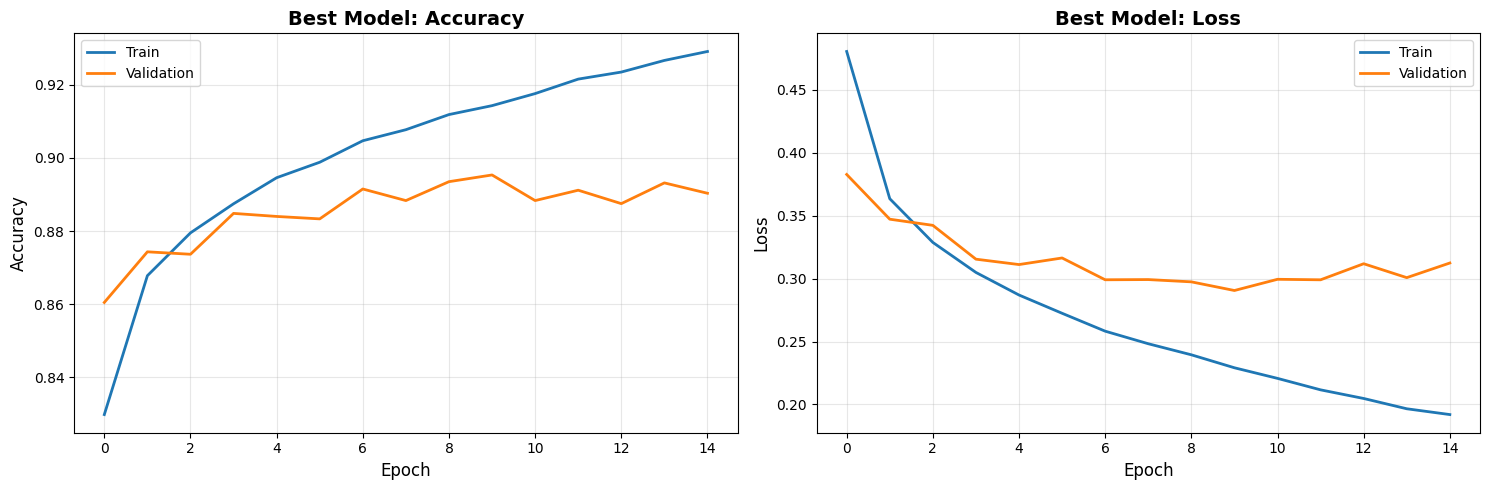

In [15]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(best_history['train_accuracy'], label='Train', linewidth=2)
ax1.plot(best_history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Best Model: Accuracy', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(best_history['train_loss'], label='Train', linewidth=2)
ax2.plot(best_history['val_loss'], label='Validation', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Best Model: Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

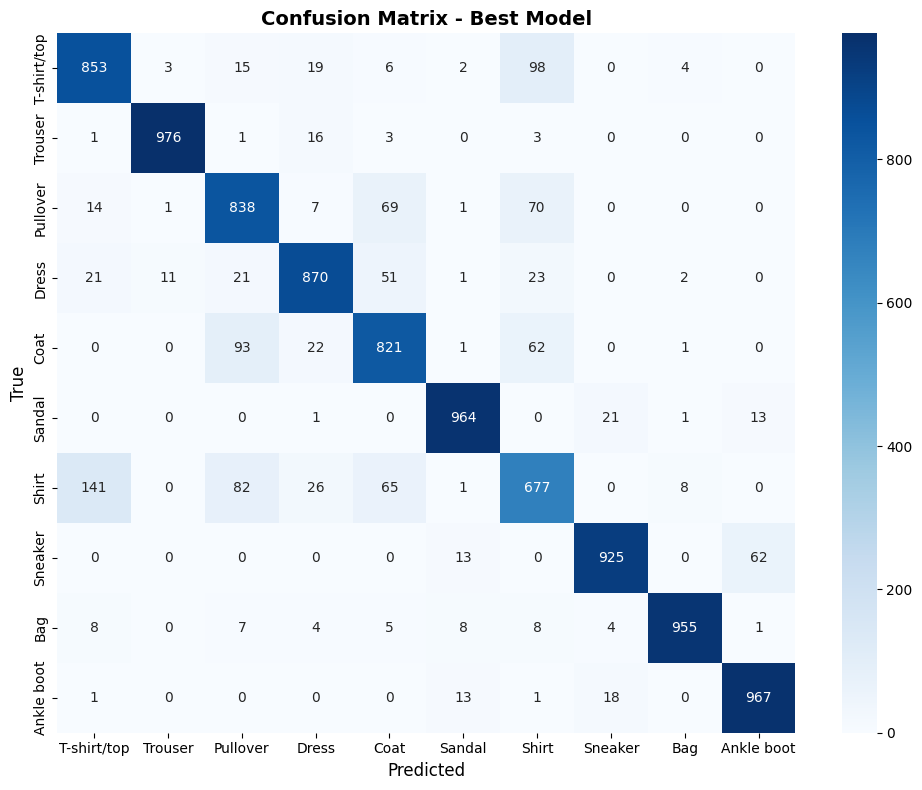

In [16]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred_proba = best_model.predict_proba(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Best Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

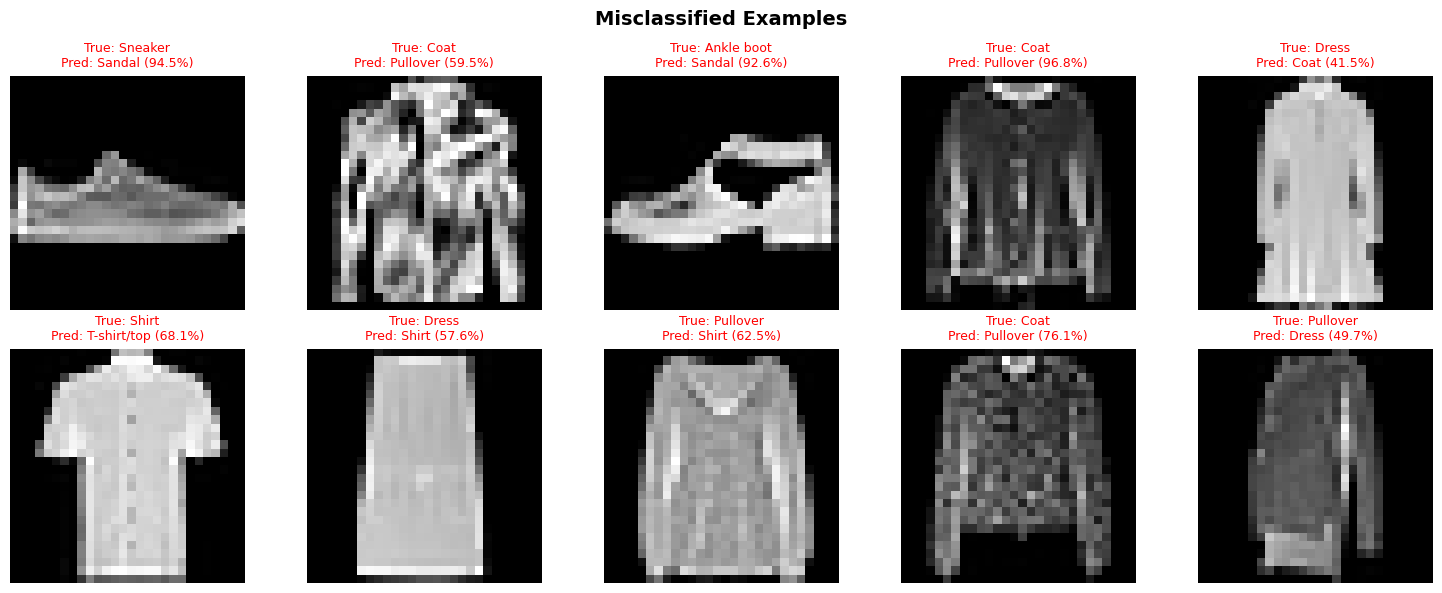

In [17]:
# Show some misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]
num_examples = min(10, len(misclassified_idx))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < num_examples:
        idx = misclassified_idx[i]
        img = x_test[idx].reshape(28, 28)
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        confidence = y_pred_proba[idx, y_pred[idx]] * 100
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
                    fontsize=9, color='red')
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Misclassified Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Summary

### Key Findings:

1. **Optimizer Selection is Critical**: Nadam and Adam significantly outperform SGD and basic momentum methods.

2. **Regularization Can Harm Performance**: For Fashion-MNIST, no regularization (L2=0) achieves the best results. Excessive regularization (L2 ≥ 0.001) causes severe underfitting.

3. **Activation Functions**: ReLU and Tanh perform similarly when properly initialized, while Sigmoid underperforms due to saturation issues.

4. **Best Configuration**: Nadam optimizer with [128, 64] architecture, Tanh activation, and no regularization achieves the highest accuracy.

The results in this notebook use fewer epochs (5-15) compared to the full report (20 epochs), so absolute accuracy values may differ slightly. However, the relative performance trends and key insights remain consistent.